In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import run_vsem_experiment
from grid_utils import (
    coverage_curve_grid, 
    plot_hpd_weights_grid,
    plot_coverage,
)

import vsem_jax as vsem
from inverse_problem import InvProb, VSEMPrior, VSEMLikelihood
from surrogate import VSEMTest

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

In [3]:
from runner import get_vsem_inv_prob

rng = np.random.default_rng(23521)
n_design = 15
n_test_grid_1d = 50

inv_prob = get_vsem_inv_prob(rng)
test = VSEMTest(inv_prob, n_design=n_design, n_test_grid_1d=n_test_grid_1d)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 64.291696
         Iterations: 39
         Function evaluations: 81
         Gradient evaluations: 72


In [22]:
cell_area = test.test_grid_info['cell_area']
U = test.test_grid_info['U_grid']
n_grid_1d = test.test_grid_info['n_grid_1d']
pred = test.gp_post_pred['pred']

logp_true = test._exact_post_grid(return_log=True)
logp_mean = test.log_post_approx_mean(U, pred=pred)
logp_eup = test.log_post_approx_eup(U, pred=pred)
logp_ep = test.log_post_approx_ep(U, pred=pred)

probs = np.linspace(0.1, 0.99, 50)

In [25]:
def get_cov(approx):
    res = coverage_curve_grid(
        logp_true,
        approx,
        probs=probs,
        cell_area=cell_area,
        return_masks=True,
        return_weights=True,
        tie_break='expand'
    )

    return np.exp(res[1])

cov_list = [get_cov(approx) for approx in (logp_mean, logp_eup, logp_ep)]
labels = ['mean', 'eup', 'ep']

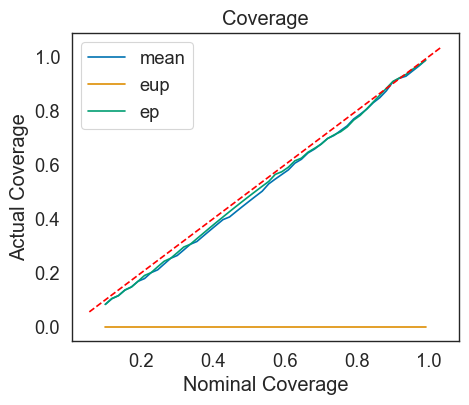

In [26]:
fig = plot_coverage(probs, cov_list, labels=labels)
display(fig)

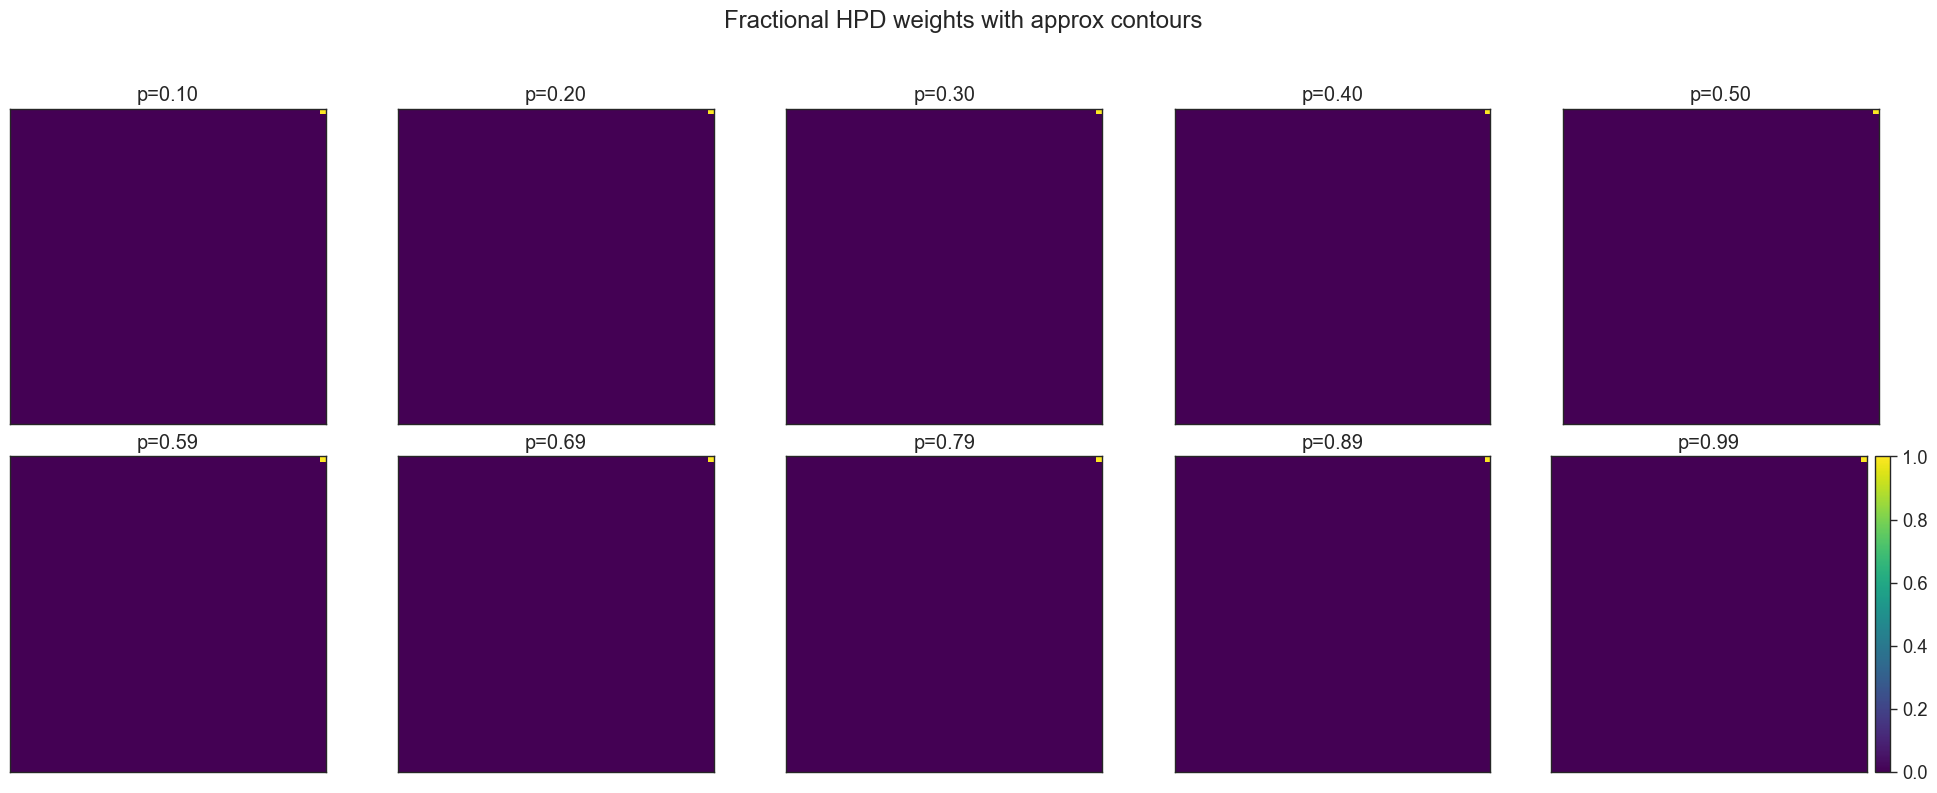

In [20]:
fig, axes_grid = plot_hpd_weights_grid(weights, grid_shape=(n_grid_1d, n_grid_1d), probs=probs,
                                       ncols=5, cmap='viridis', figsize_per_panel=(4.0, 4.0),
                                       title_fmt="p={:.2f}", show_colorbar=True,
                                       suptitle="Fractional HPD weights with approx contours")

display(fig)

In [ ]:
rng = np.random.default_rng(23521)
n_design = 15
n_test_grid_1d = 50
n_reps = 2

tests, metrics, failed = run_vsem_experiment(rng=rng, 
                                             n_design=n_design, 
                                             n_reps=n_reps, 
                                             n_test_grid_1d=n_test_grid_1d)
test = tests[0]

In [ ]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
display(fig_gp)
plt.close()

In [ ]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

display(fig_log)
display(fig)
plt.close()

In [ ]:
cell_area = test.test_grid_info['cell_area']
U = test.test_grid_info['U_grid']
n_grid_1d = test.test_grid_info['n_grid_1d']
pred = test.gp_post_pred['pred']

logp_true = test._exact_post_grid(return_log=True)
logp_approx = test.log_post_approx_mean(U, pred=pred)

In [ ]:
alphas_out, log_cov, calib_log, masks = coverage_curve_grid(
    logp_true,
    logp_approx,
    cell_area=None,
    alphas=np.concatenate([np.arange(0.1, 1.0, 0.1), np.array([0.99])]),
    return_masks=True,
    expand_ties=True,
    normalized_tol=1e-8
)

In [ ]:
print("alpha   log_coverage   coverage (linear)   calib_error_log")
for a, lc, ce in zip(alphas_out, log_cov, calib_log):
    print(f"{a:4.2f}   {lc:12.6f}   {np.exp(lc):12.6e}    {ce:12.6f}")

In [ ]:
# Plot masks
plt.close()
fig, axes = plt.subplots(1, len(alphas_out), figsize=(4 * len(alphas_out), 4))
for ax, a, mask in zip(axes, alphas_out, masks):
    plot_hpd_mask(mask, grid_shape=(n_grid_1d, n_grid_1d), ax=ax, title=f"HPD mask (alpha={a:.2f})")

plt.show()

In [ ]:
from grid_utils import logsumexp, normalize_if_not, normalize_over_grid, log_probs_are_normalized

# log_probs_are_normalized(logp_true)
p, z = normalize_if_not(logp_true, cell_area=1.0)


In [8]:
# Grid
H, W = 80, 90
xs = np.arange(W)
ys = np.arange(H)
X, Y = np.meshgrid(xs, ys)

# True distribution: sharp Gaussian
cx_true, cy_true = 44.5, 36.2
sigma_true = 3.0
logp_true_grid = -0.5 * (((X - cx_true)**2 + (Y - cy_true)**2) / sigma_true**2)

# Approx distribution: slightly shifted and wider
cx_approx, cy_approx = 46.0, 34.0
sigma_approx = 4.0
logp_approx_grid = -0.5 * (((X - cx_approx)**2 + (Y - cy_approx)**2) / sigma_approx**2)

# flatten for functions
logp_true = logp_true_grid.ravel()
logp_approx = logp_approx_grid.ravel()

# choose alphas to display
alphas = np.array([0.5, 0.9, 0.99])

# compute coverage with fractional tie-breaking and ask for weights
alphas, log_cov, masks, weights = coverage_curve_grid(
    logp_true,
    logp_approx,
    cell_area=1.0,
    probs=alphas,
    return_masks=True,
    return_weights=True,
    tie_break='fractional'
)

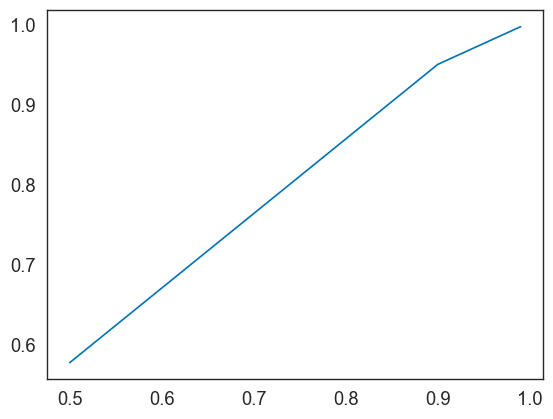

In [13]:
plt.close()
plt.plot(alphas, np.exp(log_cov))
plt.show()

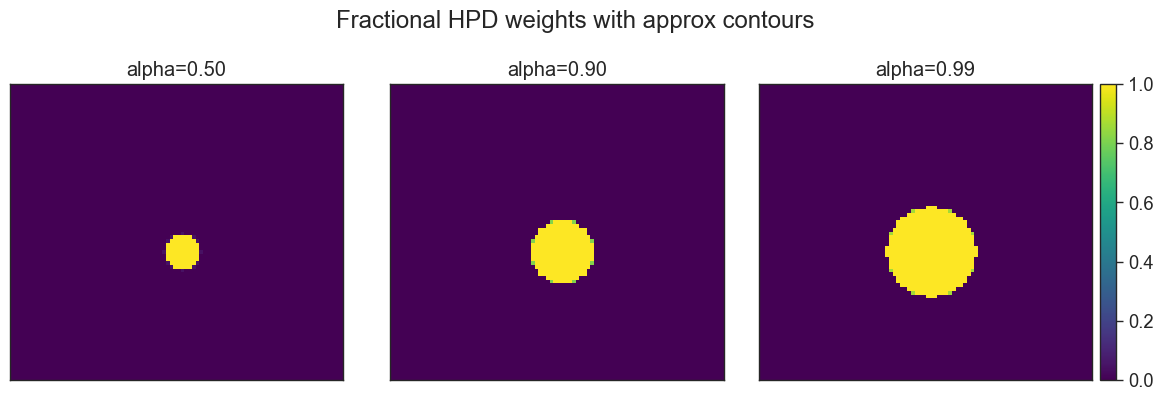

In [9]:
fig, axes_grid = plot_hpd_weights_grid(weights, grid_shape=(H, W), probs=alphas,
                                        ncols=3, cmap='viridis', figsize_per_panel=(4.0, 4.0),
                                        title_fmt="alpha={:.2f}", show_colorbar=True,
                                        suptitle="Fractional HPD weights with approx contours")

display(fig)

In [ ]:
# Plot the fractional HPD maps in a grid
fig, axes_grid = plot_hpd_weights_grid(weights, grid_shape=(H, W), probs=alphas,
                                        ncols=3, cmap='viridis', figsize_per_panel=(4.0, 4.0),
                                        title_fmt="alpha={:.2f}", show_colorbar=True,
                                        suptitle="Fractional HPD weights with approx contours")

# Overlay approximate density contours on each panel for context.
# compute approx density (normalized for nicer contour levels)
logZ_approx = _logsumexp(logp_approx)
approx_prob_grid = np.exp(logp_approx_grid - logZ_approx).reshape(H, W)

# Choose a few contour levels of the approx density for context (linear probs)
# automatic: choose 4 levels spaced on the log scale near the peak
peak_log = np.max(logp_approx_grid)
# convert to linear probabilities in a stable way relative to peak
rel = np.exp(logp_approx_grid - peak_log)
# contour on rel values (peak = 1)
cont_levels = [0.01, 0.05, 0.1, 0.3]  # relative levels
# map relative levels into actual approx_prob values by scaling with peak prob
peak_prob = np.max(approx_prob_grid)
levels = [peak_prob * c for c in cont_levels]

# axes_grid is 2D array: iterate and overlay contours on used panels
nrows, ncols = axes_grid.shape
m = weights.shape[0]
idx = 0
for r in range(nrows):
    for c in range(ncols):
        ax = axes_grid[r, c]
        if idx < m:
            # overlay contours (use same origin='lower' as imshow)
            cs = ax.contour(approx_prob_grid, levels=levels, origin='lower', linewidths=0.8, colors='k', alpha=0.8)
            # optionally label contours
            # ax.clabel(cs, inline=True, fontsize=8, fmt="%.2g")
        idx += 1

plt.show()